In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import imageio
import pandas as pd
import colorcet as cc
from matplotlib.colors import ListedColormap
import os
import shutil
import subprocess
import tempfile

import matplotlib.animation as animation

In [3]:
pixels = 1920
data85 = np.loadtxt('pixelIntensities.csv', delimiter=',', usecols=range(pixels))
dataT = np.loadtxt('times.csv', delimiter=',', usecols=range(pixels))

### Useful data manipulation functions

In [4]:
# corrects the intensity values that were zeroed due to the coordinate system singularity
def correct_zero_pixels(data):
    rows, cols = data.shape
    for i in range(rows):
        for j in range(1, cols - 1): 
            if data[i, j] == 0 and data[i, j-1] != 0 and data[i, j+1] != 0:
                data[i, j] = (data[i, j-1] + data[i, j+1]) / 2
    return data

# corrects both the intensity and time values corresponding to values that were zeroed due to the coordinate system singularity
def correct_zero_pixels_paired(data85, dataT):
    rows, cols = data85.shape
    for i in range(rows):
        for j in range(1, cols - 1): 
            if data85[i, j] == 0 and data85[i, j-1] != 0 and data85[i, j+1] != 0:
                data85[i, j] = (data85[i, j-1] + data85[i, j+1]) / 2
                dataT[i, j] = (dataT[i, j-1] + dataT[i, j+1]) / 2
    return data85, dataT

# zero the time-values corresponding to failure to reach accretion disk
def zero_corresponding_dataT(data85, dataT):
    rows, cols = data85.shape
    min_value = np.min(dataT)
    for i in range(rows):
        for j in range(cols):
            if data85[i, j] == 0:
                dataT[i, j] = min_value
    return dataT

# Perform the first correction
data85, dataT = correct_zero_pixels_paired(data85, dataT)

# Perform the second correction
dataT = zero_corresponding_dataT(data85, dataT)


### Find min and max intensity values

In [5]:
def find_min_max_in_folder(folder_path):
    min_value = float('inf')
    max_value = float('-inf')

    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path)
            
            numerical_values = df.select_dtypes(include='number')
            
            if not numerical_values.empty:
                file_min = numerical_values.min().min()
                file_max = numerical_values.max().max()
                
                if file_min < min_value:
                    min_value = file_min
                if file_max > max_value:
                    max_value = file_max

    return min_value, max_value

folder_path = #r'FILL_IN'
min_value, max_value = find_min_max_in_folder(folder_path)
print(f"The minimum value across all CSV files is: {min_value}")
print(f"The maximum value across all CSV files is: {max_value}")

The minimum value across all CSV files is: 0.0
The maximum value across all CSV files is: 2.52756


### Plot in the style of a single frame

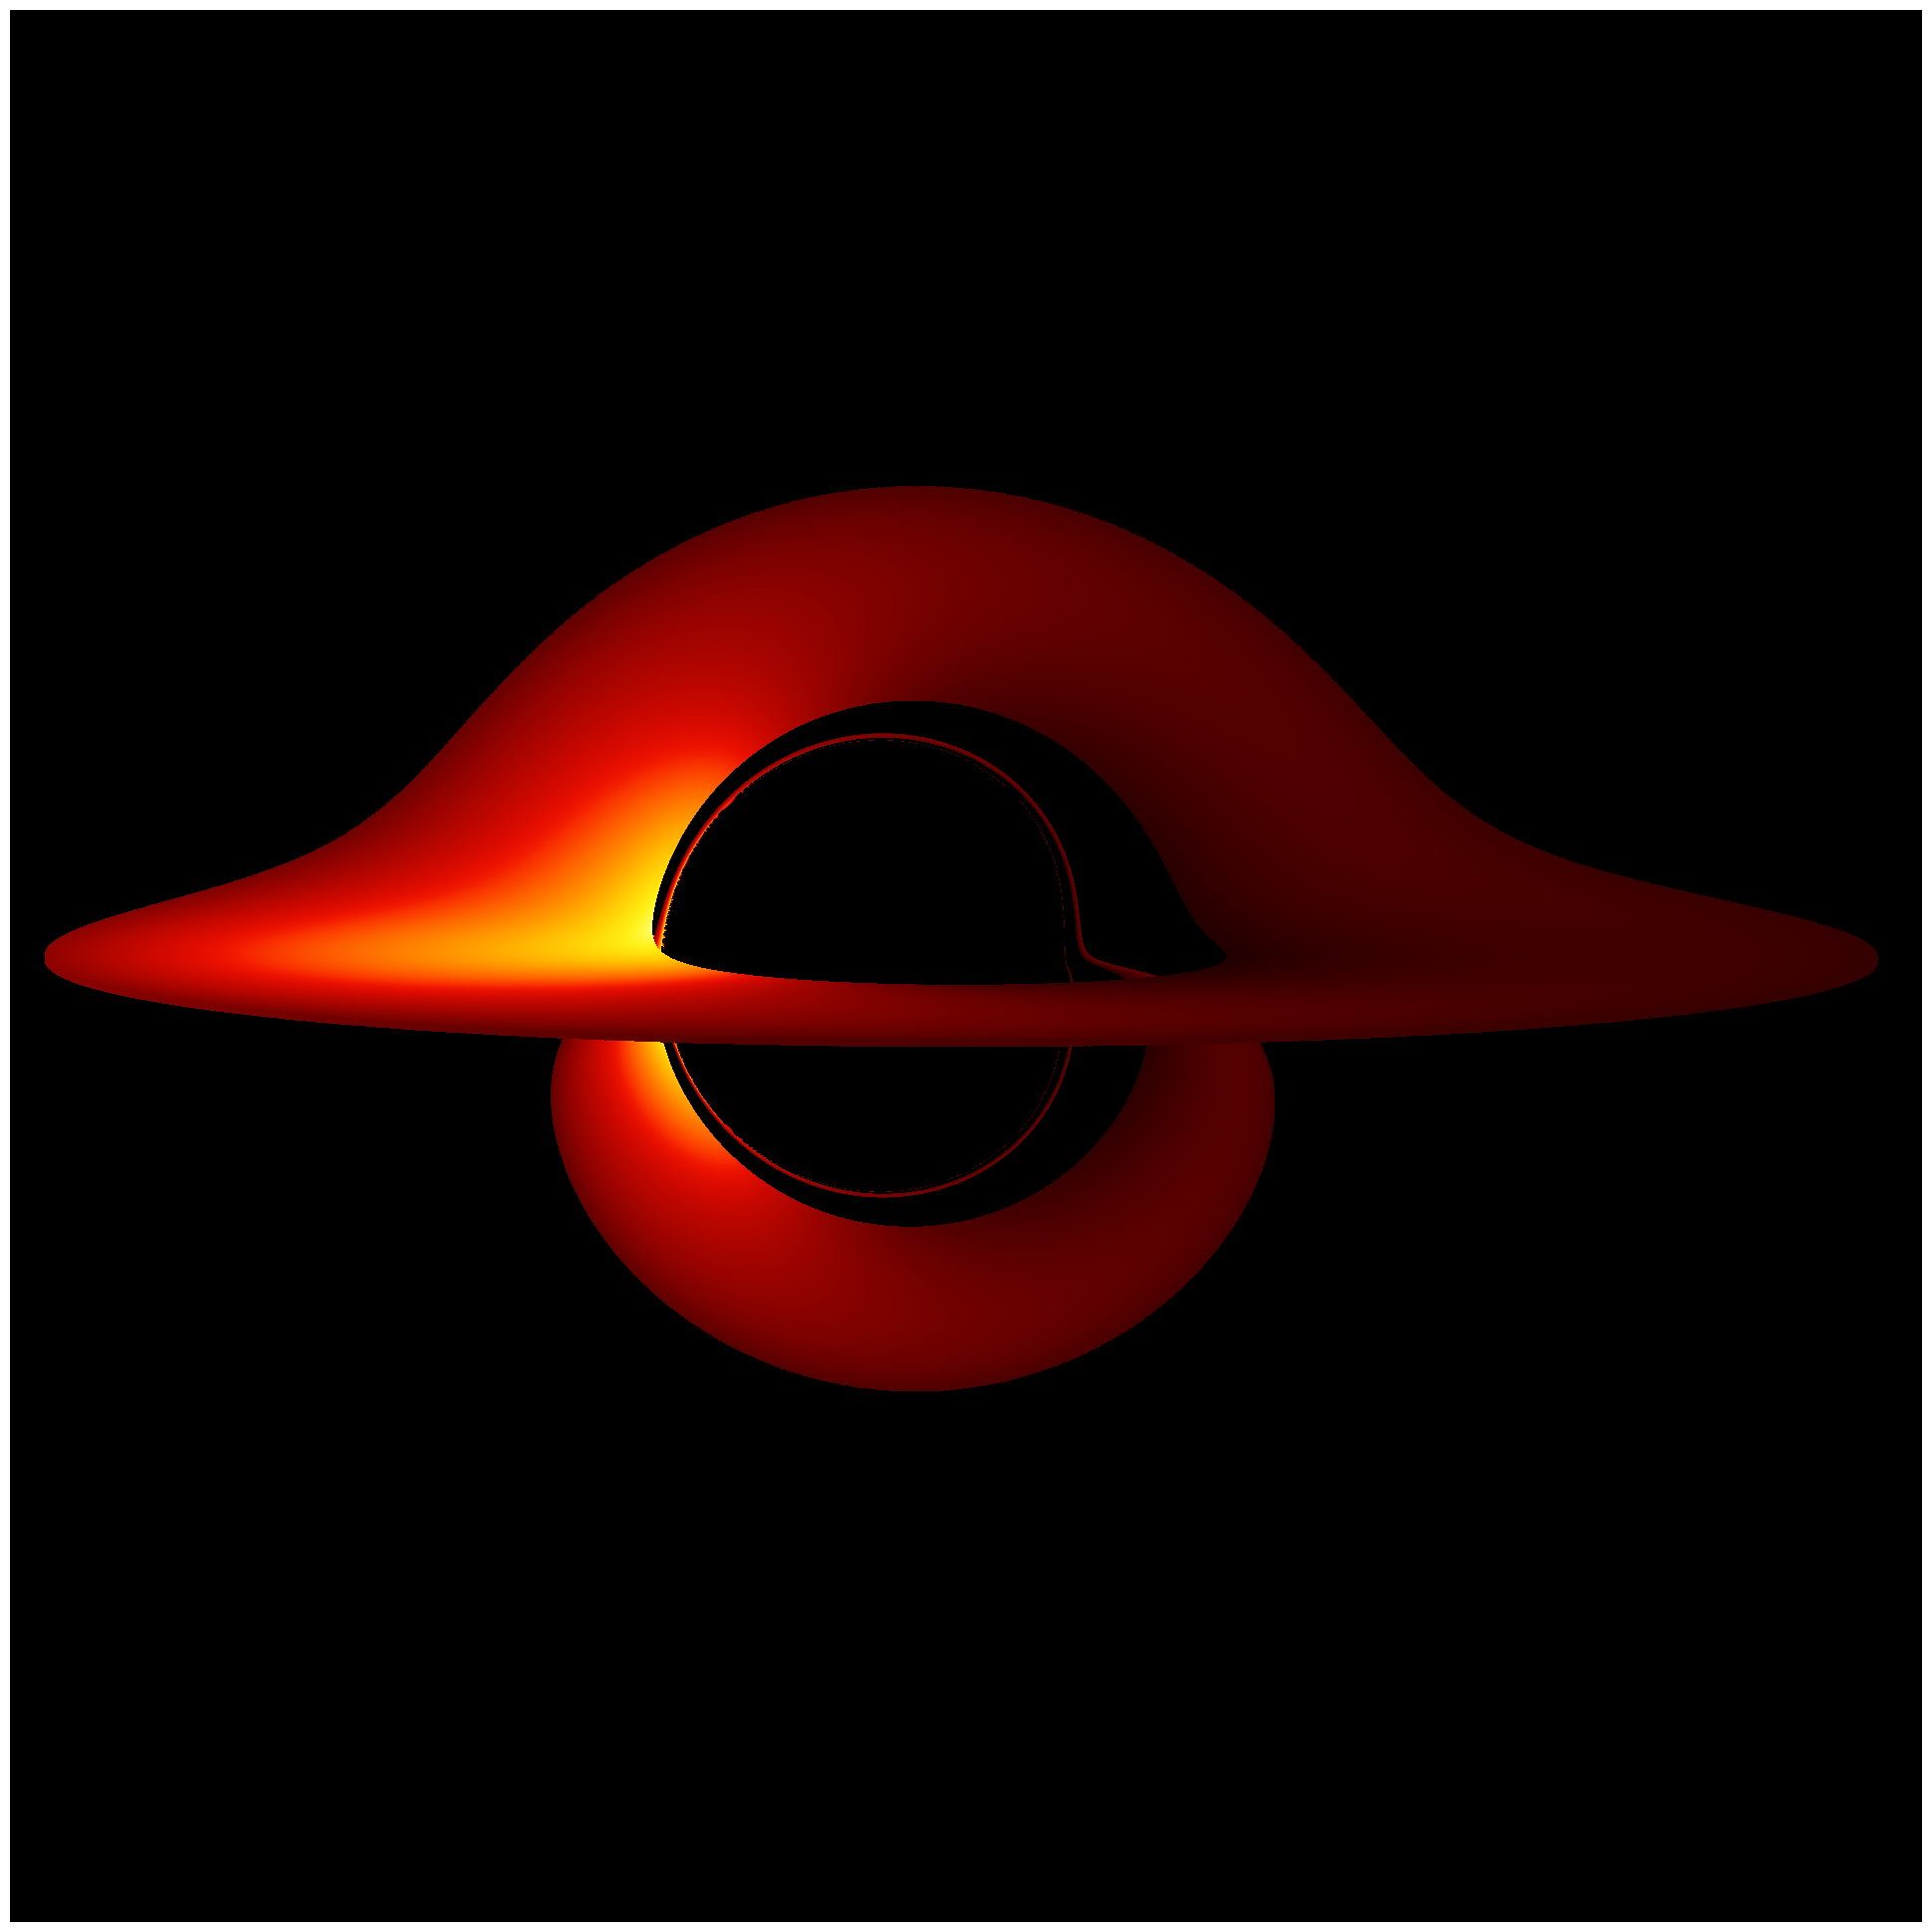

In [6]:
DPI = 100
width_inch = pixels / DPI
height_inch = pixels / DPI
fig, ax = plt.subplots(figsize=(width_inch, height_inch), dpi=DPI)
ax.axis('off')
ax.imshow(data85, cmap=cc.cm.CET_L3, vmin=min_value, vmax=max_value)
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0, 0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.show()

### Produce frames showing raytracing order

In [ ]:
# Parameters for the animation
total_duration = 3  
fps = 60  
total_frames = total_duration * fps

# Scaling the time data so that it gives the display frames for the corresponding intensity data
min_time = np.min(dataT)
max_time = np.max(dataT)
scaled_dataT = ((dataT - min_time) / (max_time - min_time)) * (total_frames - 1)
scaled_dataT = scaled_dataT.astype(int)

output_dir = #r'FILL_IN'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

image = np.zeros_like(data85)
def save_frame(frame, image, scaled_dataT, data85):
    DPI = 100
    width_inch = pixels / DPI
    height_inch = pixels / DPI
    fig, ax = plt.subplots(figsize=(width_inch, height_inch), dpi=DPI)
    ax.axis('off')
    
    mask = (scaled_dataT == frame)
    image[mask] = data85[mask]
    
    ax.imshow(image, cmap=cc.cm.CET_L3, vmin=min_value, vmax=max_value)
    
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    plt.margins(0, 0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    
    filename = f'frame_{frame:04d}.png'
    filepath = os.path.join(output_dir, filename)
    fig.savefig(filepath, dpi=DPI, pad_inches=0, transparent=True, format='png')
    plt.close(fig)

for frame in range(total_frames):
    save_frame(frame, image, scaled_dataT, data85)

print(f'Saved {total_frames} frames to {output_dir}')

### Produce frames showing orbit

In [ ]:
def load_data(filepath):
    return np.loadtxt(filepath, delimiter=',', usecols=range(pixels))

def save_frame(data, frame_number, output_dir):
    data = correct_zero_pixels(data)
    
    DPI = 100
    width_inch = pixels / DPI
    height_inch = pixels / DPI
    fig, ax = plt.subplots(figsize=(width_inch, height_inch), dpi=DPI)
    ax.axis('off')
    
    ax.imshow(data, cmap=cc.cm.CET_L3, vmin=min_value, vmax=max_value)  
    
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    plt.margins(0, 0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    
    filename = f'frame_{frame_number:04d}.png'
    filepath = os.path.join(output_dir, filename)
    fig.savefig(filepath, dpi=DPI, pad_inches=0, transparent=True, format='png')
    plt.close(fig)

csv_dir = #r'FILL_IN'
output_dir = #r'FILL_IN'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

frame_counter = total_frames
angles = list(range(87, 180, 2)) + list(range(1, 180, 2)) + list(range(1, 86, 2))

cam_angle = 87
for angle in angles:
    filename = f'{angle:.6f}.csv'
    filepath = os.path.join(csv_dir, filename)
    
    if cam_angle < 180 or cam_angle > 360:
        data = load_data(filepath)
    else:
        data = np.flip(load_data(filepath), axis=1)  # Flip over the vertical axis for angles > 180 (the back of the blackhole is just the front flipped ; it takes less time to flip an image than to raytrace a new one)
    save_frame(data, frame_counter, output_dir)
    frame_counter += 1
    cam_angle += 2

print(f'Saved frames to {output_dir}')

### Produce basic animation

In [ ]:

frames_dir = #r'FILL_IN'
output_video_path = #r'FILL_IN'

frames = [os.path.join(frames_dir, f'frame_{i:04d}.png') for i in range(360)]

fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
fps = 60  
width, height = pixels, pixels
video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

for frame_path in frames:
    frame = cv2.imread(frame_path)
    video_writer.write(frame)

video_writer.release()

print(f'Video saved to {output_video_path}')


### Make a completely black frame

In [ ]:
frames_dir = #r'FILL_IN'
black_frame = np.zeros((pixels, pixels, 3), dtype=np.uint8)
output_black_frame_path = os.path.join(frames_dir, 'frame_0360.png')
cv2.imwrite(output_black_frame_path, black_frame)
print(f'Black frame saved to {output_black_frame_path}')

### Produce more complex animation

In [ ]:
frames_dir = #r'FILL_IN'
output_video_path = #r'FILL_IN' # include video name at the ends of the path

frames_forward = [os.path.join(frames_dir, f'frame_{i:04d}.png') for i in range(360)]
frames_rot = [os.path.join(frames_dir, f'frame_{i:04d}.png') for i in range(179, 360)]
frames_backward = [os.path.join(frames_dir, f'frame_{i:04d}.png') for i in range(179, -1, -1)]
dark_frame = [os.path.join(frames_dir, 'frame_0360.png')]

num_rotations_middle = 2
frames_sequence = dark_frame + frames_forward + (frames_rot * num_rotations_middle) + frames_backward + dark_frame

fourcc = cv2.VideoWriter_fourcc(*'mp4v')  
fps = 45  
width, height = pixels, pixels  
video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

for frame_path in frames_sequence:
    frame = cv2.imread(frame_path)
    video_writer.write(frame)

video_writer.release()

print(f'Video saved to {output_video_path}')


### Produce Higher Quality Anmation

In [ ]:
frames_dir = #r'FILL_IN'
output_video_path = 'output_video.mp4'

with tempfile.TemporaryDirectory() as temp_dir:
    for index, frame_path in enumerate(frames_sequence):
        unique_frame_path = os.path.join(temp_dir, f'frame_{index:04d}.png')
        shutil.copy(frame_path, unique_frame_path)

    ffmpeg_command = [
        'ffmpeg',
        '-framerate', str(fps),
        '-i', os.path.join(temp_dir, 'frame_%04d.png'), 
        '-c:v', 'libx265',
        '-preset', 'veryslow',
        '-crf', '0', 
        '-pix_fmt', 'yuv444p', 
        '-vf', f'scale={pixels}:{pixels}',
        output_video_path
    ]

    print('Running FFmpeg command:', ' '.join(ffmpeg_command))

    subprocess.run(ffmpeg_command, check=True)
    
    print(f'Video saved to {output_video_path}')